<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Looking at Parameter Identifiability

Sensitivity analyses can mask other artifacts that affect calibration and uncertainty. A primary issues is correlation between parameters.  For example, we saw that in a heads-only calibration we can't estimate both recharge and hydraulic conductivity independently - the parameters are correlated so that an increase in one can be offset with an increase in the other.  To address this shortcoming, Doherty and Hunt (2009) show that singular value decomposition can extend the sensitivity insight into __*parameter identifiability*__.  Parameter identifiability combines parameter insensitivity and correlation information, and reflects the robustness with which particular parameter values in a model might be calibrated. That is, an identifiable parameter is both sensitive and relatively uncorrelated and thus is more likely to be estimated (identified) than an insensitive and/or correlated parameter. 

Parameter identifiability is considered a "linear method" in that it assumes the Jacobian matrix sensitivities hold over a range of reasonable parameter values.  It is able to address parameter correlation through singular value decomposition (SVD), exactly as we've seen earlier in this course.  Parameter identifiability ranges from 0 (perfectly unidentifiable with the observations available) to 1.0 (fully identifiable). So, we typically plot identifiability using a stacked bar chart which is comprised of the included singular value contributions. Another way to think of it: if a parameter is strongly in the SVD solution space (low singular value so above the cutoff) it will have a higher identifiability. However, as Doherty and Hunt (2009) point out, identifiability is qualitative in nature because the singular value cutoff is user specified. 

You can access parameter identifiability at the command line using the PEST utility __*identpar*__.  As always, when you type identpar without arguments you'll get what the utility needs to run. For identpar.exe it looks like:



    IDENTPAR Version 14.01. Watermark Numerical Computing.


    IDENTPAR is run using the command:

        IDENTPAR casename numvec outbase matfile identfile [/s or /r]

    where

        casename  is a PEST control file basename,
        numvec    is the number of singular values to use,
        outbase   is the filename base of sensitivity vector output files,
        outfile   is the name of a matrix output file
        identfile is the name of a parameter identifiability output file, and
        /s or /r  instigates SVD on XtQX or Q^(1/2)X respectively (/s is default).

        Note: enter a filename of "null" for no pertinent output file.


The input of __numvec__ specifies the singular value cutoff that is used to calculate identifiability; the __identfile__ above provides the output in a format suitable for plotting.  

However, in our example here __we won't use the command line PEST utility__ but will instead take advantage of the pyemu version of parameter identifiability for convenience. Let's take a look at it more closely and see what we can learn from it and how to handle such information as the number of parameters rises.

### One last cool concept about identifiability the Doherty and Hunt (2009) point out:  
Because parameter identifiability uses the Jacobian matrix it is the *sensitivity* that matters, not the actual value specified. This means you can enter *hypothetical observations* to the existing observations, re-run the Jacobian matrix, and then re-plot identifiability. In this way identifiability becomes a quick but qualitative way to look at the worth of future data collection - an underused aspect of our modeling!   

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import pyemu
import os, shutil
import re
from matplotlib.backends.backend_pdf import PdfPages
runall= False
import identifiability_helper as ih

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'inschek', 'inschek.exe', 'kzone.ref', 'mf2005', 'mf2005.exe', 'mfnwt', 'mp6', 'mp6.exe', 'mpath.in', 'obs_loc.csv', 'pest++.exe', 'pestchek', 'pestchek.exe', 'pestpp', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'sweep', 'sweep.exe', 'tempchek', 'tempchek.exe', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following 

In [3]:
obslox = pd.read_csv(os.path.join(working_dir,'freyberg.hyd'), delim_whitespace=True, usecols = [4,5,6], 
                     index_col=2, skiprows = 1, header=None, names=['X','Y','obsname'])
obslox = obslox.drop([i for i in obslox.index if not i.startswith('cr')], axis=0)
parlox = pd.read_csv(os.path.join(working_dir,'hkpp.dat.tpl'), delim_whitespace=True, usecols=[0,1,2],
                    index_col=0, skiprows=1, header=None, names=['parname','X','Y'])
parlox['pp_num'] = [re.findall('\d+',i)[0] for i in parlox.index.values]

# We need to calculate a Jacobian Matrix to look at sensitivity and identifiability

## we just need to sen `NOPTMAX=-1` in the PST control file and run PESTPP

In [4]:
inpst = pyemu.Pst(os.path.join(working_dir,'freyberg_pp.pst'))
inpst.control_data.noptmax=-1
inpst.write(os.path.join(working_dir,'freyberg_jac.pst'))

In [5]:
if runall==True:
    os.chdir(working_dir)
    pyemu.helpers.run('pestpp freyberg_jac.pst')
    os.chdir('..')
else:
    shutil.copy2('freyberg_jac.jcb', os.path.join(working_dir,'freyberg_jac.jcb'))

# Let's load up the resulting Jacobian and look at sensitivity and identifiability

In [6]:
ev = pyemu.ErrVar(jco=os.path.join(working_dir,'freyberg_jac.jcb'))

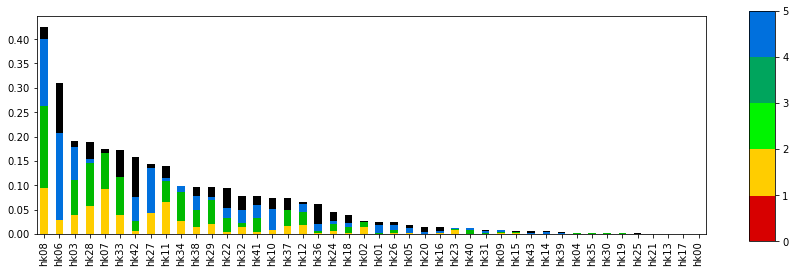

In [7]:
id = ih.plot_id_bars(ev, 5)

In [8]:
id.head()

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,right_sing_vec_6,right_sing_vec_7,right_sing_vec_8,right_sing_vec_9,right_sing_vec_10,right_sing_vec_11,right_sing_vec_12,ident
rch_0,9.737176e-01,0.009020,0.000117,0.000325,0.000010,0.000425,0.000080,0.000008,0.000031,0.000233,0.000075,0.000862,0.984903
hk27,1.627802e-07,0.043652,0.000251,0.091767,0.008092,0.082610,0.108119,0.053949,0.272815,0.003233,0.000101,0.000702,0.665290
hk21,2.398289e-09,0.000011,0.000012,0.000044,0.000570,0.009309,0.005824,0.005367,0.001303,0.588852,0.004540,0.031709,0.647542
hk24,2.972889e-07,0.005607,0.014448,0.005891,0.019961,0.216359,0.008615,0.088566,0.133698,0.011980,0.000048,0.022907,0.528079
hk07,7.177525e-07,0.091707,0.075068,0.000041,0.007715,0.000226,0.002953,0.005035,0.004054,0.000484,0.304934,0.000044,0.492261


In [ ]:
np.linspace(1,4,4)

In [9]:
id.plot(kind='bar',stacked=True, legend=False, cmap='magma', figsize=(12,4))

AttributeError: 'builtin_function_or_method' object has no attribute 'plot'

In [ ]:
ident = id.sum(axis=1)
ident

In [17]:
la = pyemu.LinearAnalysis(jco=os.path.join(working_dir,'freyberg_jac.jcb'))

In [19]:
la.get_par_css_dataframe()

,pest_css,hill_css
rch_0,92.229968,0.000000
rch_1,0.000000,0.000000
hk00,0.024305,0.001213
hk01,0.237432,0.011854
hk02,0.494057,0.024666
hk03,0.993549,0.049604
hk04,0.128209,0.006401
hk05,0.227705,0.011368
hk06,0.947230,0.047292
hk07,1.234452,0.061632


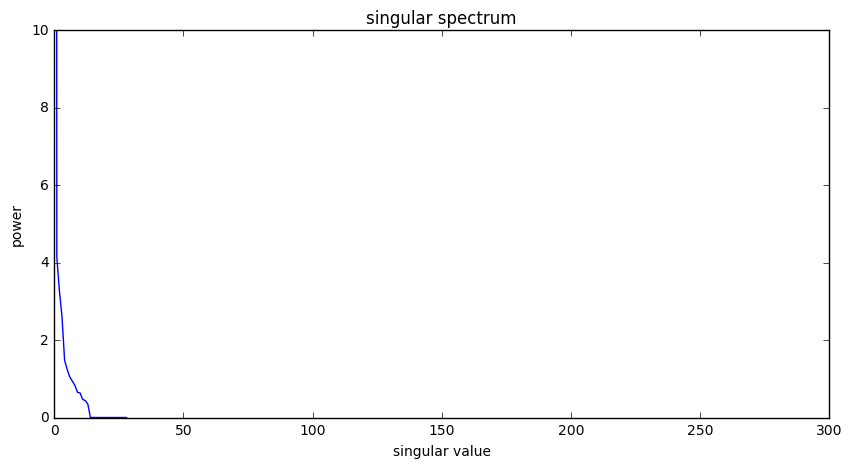

In [5]:
ax=idpar.plot_singular_spectrum()


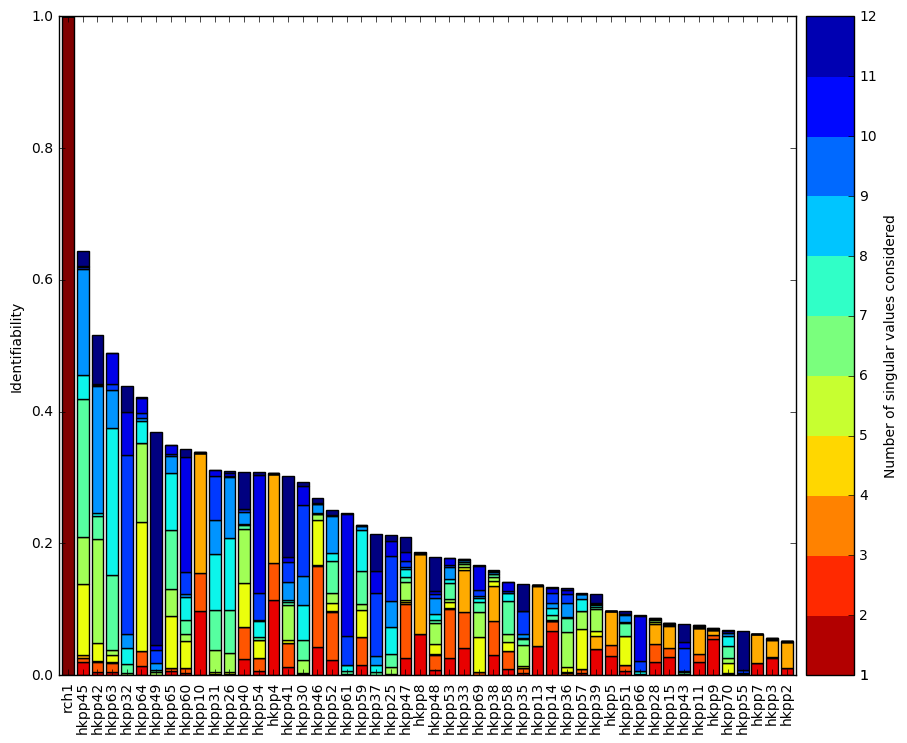

In [13]:
idpar.plot_bar(nsingular=12,nbars=50);

### How does this compare with CSS?

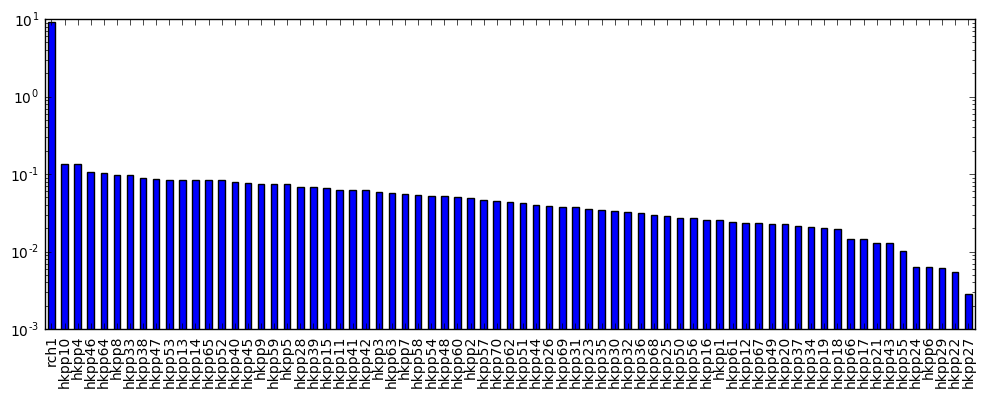

In [11]:
la = pyemu.LinearAnalysis(jco='freyberg_pp_reg_phimlim26.jcb')
plt.figure(figsize=(12,4))
ax = la.get_par_css_dataframe()['pest_css'].sort_values(ascending=False).plot(kind='bar')
ax.set_yscale('log')

### We can read in the covariance and look at correlation

In [14]:
sc = pyemu.Schur('freyberg_pp_reg_phimlim26.jcb')
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df().head()

,rch1,hkpp1,hkpp2,hkpp3,hkpp4,hkpp5,hkpp6,hkpp7,hkpp8,hkpp9,...,hkpp61,hkpp62,hkpp63,hkpp64,hkpp65,hkpp66,hkpp67,hkpp68,hkpp69,hkpp70
rch1,16384.411155,-8.042722,-11.205055,-11.299631,-27.371374,-12.716729,-0.647991,-4.248365,-12.029838,-16.859350,...,3.317644,-66.798824,-5.269363,123.002067,111.164084,-5.287160,-37.532638,-39.493487,-14.242107,67.803412
hkpp1,-8.042722,0.125665,0.240938,0.273183,0.099716,0.023083,0.001622,0.274229,0.480974,0.292958,...,-0.000260,0.052575,0.049947,0.032666,0.009129,0.000615,0.018999,0.022632,0.022378,0.001600
hkpp2,-11.205055,0.240938,0.464242,0.520208,0.128406,0.009229,0.001322,0.527310,0.920649,0.542838,...,0.000287,0.085077,0.096002,0.094799,0.045501,-0.000100,0.027854,0.034655,0.040721,0.019917
hkpp3,-11.299631,0.273183,0.520208,0.695250,0.625112,0.255390,0.013738,0.605385,1.063474,0.792647,...,0.001688,0.087248,0.121150,0.163139,0.096282,-0.001792,0.023169,0.031407,0.047613,0.048495
hkpp4,-27.371374,0.099716,0.128406,0.625112,3.520772,1.916600,0.091868,0.298206,0.663434,1.366817,...,0.001385,0.097592,0.122369,0.149274,0.084439,-0.001460,0.026534,0.034353,0.045410,0.041980


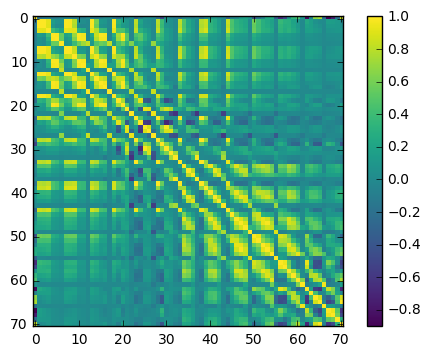

In [15]:
R = covar.to_pearson()
plt.imshow(R.df(), interpolation='nearest', cmap='viridis')
plt.colorbar()

### Let's look at correlation
CSS suffers from the challenge that values with high CSS may be corelated with other parameters. We can check that out. Identifiability, on the other hand, tends to spread among the correlated parameters so that identifiability is suppressed from each of those parameters. This makes a big difference between what is "sensitive" vs. "identifiable"

In [18]:
cpar = 'hkpp10'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5]

hkpp4     0.989381
hkpp5     0.980060
hkpp6     0.577949
hkpp9     0.637666
hkpp10    1.000000
hkpp11    0.971393
hkpp14    0.806810
hkpp15    0.994621
hkpp16    0.974520
hkpp19    0.745730
hkpp20    0.977428
hkpp24    0.528873
Name: hkpp10, dtype: float64

## this is also good look at spatially

In [19]:
def plot_identifiability_spatial(idp, nsingular, parlox, obslox,makelabels=False,figsize=(4,7)):
    ident_df = idp.la.get_identifiability_dataframe(nsingular)
    ident_df=ident_df[['ident']].join(parlox)    
    ident_df.drop('rch1',inplace=True)
    plt.figure(figsize=figsize)
    plt.plot(obslox.X, obslox.Y,'x')
    plt.scatter(ident_df.X, ident_df.Y, s=np.abs(ident_df.ident.values)*100,
                c=ident_df.ident.values, cmap='viridis')
    if makelabels:
        for cn, cg in pd.groupby(parlox, by='pp_num'):
            plt.gca().annotate(cn, xy=(cg.X,cg.Y), textcoords='data', fontsize=9)
    plt.axis('equal')
    plt.colorbar()
    plt.title('Identifiability with {0} singular values'.format(nsingular))
    plt.xlim(0,5000)
    plt.ylim(0,10000)
    plt.axis('off')

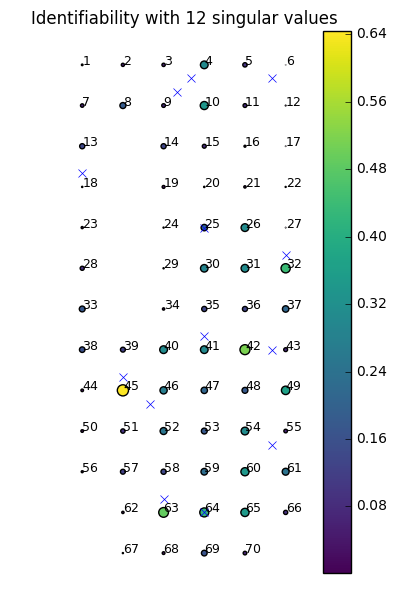

In [22]:
plot_identifiability_spatial(idpar,12,parlox, obslox, makelabels=True)